In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import re
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import *
from alphalens.plotting import *
from alphalens.tears import *

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sns.set_style('whitegrid')

In [4]:
performance = pd.read_pickle('single_factor.pickle')
performance.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2015-01-02 21:00:00+00:00 to 2017-12-29 21:00:00+00:00
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   period_open              755 non-null    datetime64[ns, UTC]
 1   period_close             755 non-null    datetime64[ns, UTC]
 2   returns                  755 non-null    float64            
 3   portfolio_value          755 non-null    float64            
 4   longs_count              755 non-null    int64              
 5   shorts_count             755 non-null    int64              
 6   long_value               755 non-null    float64            
 7   short_value              755 non-null    float64            
 8   long_exposure            755 non-null    float64            
 9   pnl                      755 non-null    float64            
 10  capital_used             755 non-null    float64 

In [5]:
prices = pd.concat([df.to_frame(d) for d, df in performance.prices.dropna().items()],axis=1).T
'''
    1) dropna:performance.prices.shape[0]=755 performance.prices.dropna().shape[0]=754
    2) 对series类型做items操作，会把index和value转化为zip迭代类型,此时d为timestamp，df为长度为1000的series(股票为index，price为value)
    3) df.to_frame(d),把df从series转为dataframe，股票为index，timestamp为column
    4) concat把n*1的dataframe转为n*m的dataframe，index为股票，columns为日期
    5) .T把4)中dataframe转为index为日期，columns为股票;注意股票数是会>1000的，因为factor每天计算出的成交量前1000，各天结果有不重合
'''
prices.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in prices.columns] #Equity(8 [AAPL])变为'AAPL'
prices.index = prices.index.normalize()  #对齐时间格式，'2015-01-05 21:00:00+00:00' -> '2015-01-05 00:00:00+00:00'
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1649 entries, A to NETE
dtypes: float64(1649)
memory usage: 9.5 MB


In [6]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.dropna().items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data.info()
factor_data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2015-01-05 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 1649 entries, A to NETE
dtypes: float64(1649)
memory usage: 9.5 MB


,A,AAL,AAP,AAPL,ABBV,ABC,ABG,ABT,ACAD,ACC,...,CHE,EGBN,HAE,NYT,APTV,AVAV,GDOT,GTN,RVNC,NETE
2015-01-05 00:00:00+00:00,2707.0,870.0,1253.0,2977.0,2806.0,2626.0,2515.0,2743.0,1663.0,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00+00:00,2707.0,870.0,1253.0,2977.0,2806.0,2626.0,2515.0,2743.0,1663.0,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00+00:00,2707.0,870.0,1253.0,2977.0,2806.0,2626.0,2515.0,2743.0,1663.0,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00+00:00,2707.0,870.0,1253.0,2977.0,2806.0,2626.0,2515.0,2743.0,1663.0,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09 00:00:00+00:00,2707.0,870.0,1253.0,2977.0,2806.0,2626.0,2515.0,2743.0,1663.0,448.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
factor_data = pd.concat([df.to_frame(d) for d, df in performance.factor_data.dropna().items()],axis=1).T
factor_data.columns = [re.findall(r"\[(.+)\]", str(col))[0] for col in factor_data.columns]
factor_data.index = factor_data.index.normalize()
factor_data = factor_data.stack()
factor_data.index.names = ['date', 'asset']
factor_data.info()
factor_data.head(2)

<class 'pandas.core.series.Series'>
MultiIndex: 752773 entries, (Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2017-12-29 00:00:00+0000', tz='UTC'), 'NETE')
Series name: None
Non-Null Count   Dtype  
--------------   -----  
752773 non-null  float64
dtypes: float64(1)
memory usage: 8.7+ MB


date                       asset
2015-01-05 00:00:00+00:00  A        2707.0
                           AAL       870.0
dtype: float64

In [8]:
with pd.HDFStore('../data/assets.h5') as store:
    sp500 = store['sp500/stooq'].close
#sp500.head(3)
sp500 = sp500.resample('D').ffill().tz_localize('utc').filter(prices.index.get_level_values(0)) 
sp500.head(3)

Date
2015-01-05 00:00:00+00:00    2020.58
2015-01-06 00:00:00+00:00    2002.61
2015-01-07 00:00:00+00:00    2025.90
Name: close, dtype: float64

In [9]:
HOLDING_PERIODS = (5, 10, 21, 42)
QUANTILES = 5
alphalens_data = get_clean_factor_and_forward_returns(factor=factor_data,
                                                      prices=prices,
                                                      periods=HOLDING_PERIODS,
                                                      quantiles=QUANTILES)

Dropped 5.6% entries from factor data: 5.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [11]:
alphalens_data.info()
alphalens_data.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 710849 entries, (Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), 'A') to (Timestamp('2017-10-30 00:00:00+0000', tz='UTC'), 'SEM')
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   5D               710849 non-null  float64
 1   10D              710849 non-null  float64
 2   21D              710849 non-null  float64
 3   42D              710849 non-null  float64
 4   factor           710849 non-null  float64
 5   factor_quantile  710849 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 35.3+ MB


5D       10D       21D       42D  \
date                      asset                                           
2015-01-05 00:00:00+00:00 A      0.007789 -0.046985 -0.027889  0.072864   
                          AAL   -0.079722 -0.020882 -0.095684 -0.103295   
                          AAP    0.015722 -0.024350 -0.003196 -0.010865   
                          AAPL   0.028235  0.023247  0.116518  0.214965   
                          ABBV   0.017169 -0.018561 -0.061098 -0.064811   

                                 factor  factor_quantile  
date                      asset                           
2015-01-05 00:00:00+00:00 A      2707.0                5  
                          AAL     870.0                1  
                          AAP    1253.0                2  
                          AAPL   2977.0                5  
                          ABBV   2806.0                5

In [13]:
a = alphalens_data.reset_index()
a.info()
a.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710849 entries, 0 to 710848
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   date             710849 non-null  datetime64[ns, UTC]
 1   asset            710849 non-null  object             
 2   5D               710849 non-null  float64            
 3   10D              710849 non-null  float64            
 4   21D              710849 non-null  float64            
 5   42D              710849 non-null  float64            
 6   factor           710849 non-null  float64            
 7   factor_quantile  710849 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 43.4+ MB


,date,asset,5D,10D,21D,42D,factor,factor_quantile
0,2015-01-05 00:00:00+00:00,A,0.007789,-0.046985,-0.027889,0.072864,2707.0,5
1,2015-01-05 00:00:00+00:00,AAL,-0.079722,-0.020882,-0.095684,-0.103295,870.0,1
2,2015-01-05 00:00:00+00:00,AAP,0.015722,-0.024350,-0.003196,-0.010865,1253.0,2
3,2015-01-05 00:00:00+00:00,AAPL,0.028235,0.023247,0.116518,0.214965,2977.0,5
4,2015-01-05 00:00:00+00:00,ABBV,0.017169,-0.018561,-0.061098,-0.064811,2806.0,5


In [14]:
alphalens_data.reset_index().head().to_csv('factor_data.csv', index=False) 

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,1.0,1011.0,303.057978,188.562449,142313,20.020145
2,352.0,1636.0,856.678631,234.705707,142117,19.992572
3,794.0,2153.0,1417.174265,259.942787,142019,19.978786
4,1273.0,2621.0,1979.178578,253.504821,142117,19.992572
5,1827.0,3050.0,2519.578804,227.348609,142283,20.015925


Returns Analysis


,5D,10D,21D,42D
Ann. alpha,0.046,0.036,0.009,0.001
beta,0.083,0.098,0.077,0.019
Mean Period Wise Return Top Quantile (bps),11.724,9.110,3.948,-0.376
Mean Period Wise Return Bottom Quantile (bps),-16.862,-13.259,-4.742,-1.979
Mean Period Wise Spread (bps),28.587,22.343,8.711,1.582


Information Analysis


,5D,10D,21D,42D
IC Mean,0.022,0.026,0.017,0.003
IC Std.,0.140,0.127,0.116,0.115
Risk-Adjusted IC,0.160,0.207,0.148,0.027
t-stat(IC),4.261,5.529,3.953,0.729
p-value(IC),0.000,0.000,0.000,0.466
IC Skew,0.372,0.266,0.115,0.113
IC Kurtosis,0.054,-0.515,-0.333,-0.557


Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 640x480 with 0 Axes>

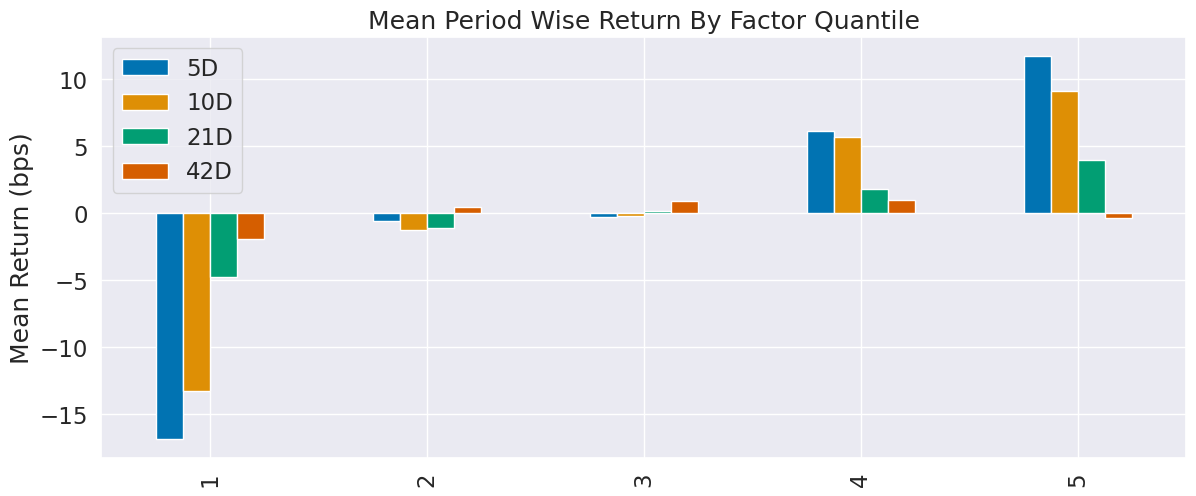

In [15]:
create_summary_tear_sheet(alphalens_data)

In [22]:
mean_return_by_q, std_err = mean_return_by_quantile(alphalens_data)
mean_return_by_q_norm = mean_return_by_q.apply(lambda x: x.add(1).pow(1/int(x.name[:-1])).sub(1))

In [26]:
mean_return_by_q.info()
mean_return_by_q.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 1 to 5
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5D      5 non-null      float64
 1   10D     5 non-null      float64
 2   21D     5 non-null      float64
 3   42D     5 non-null      float64
dtypes: float64(4)
memory usage: 200.0 bytes


,5D,10D,21D,42D
factor_quantile,,,,
1,-0.001686,-0.002650,-0.001990,-0.001661
2,-0.000061,-0.000250,-0.000471,0.000389
3,-0.000032,-0.000052,0.000053,0.000758
4,0.000608,0.001130,0.000752,0.000837
5,0.001172,0.001823,0.001659,-0.000316


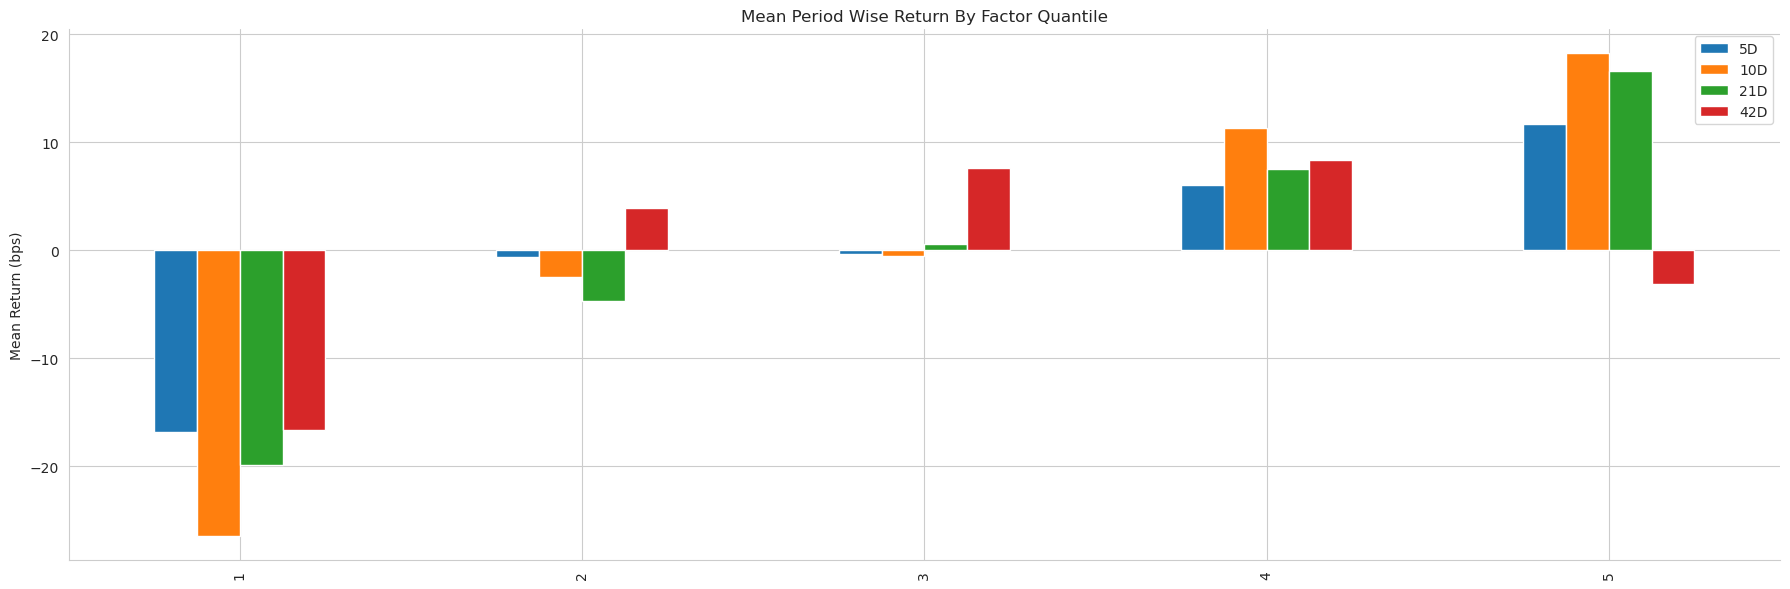

In [23]:
plot_quantile_returns_bar(mean_return_by_q)
plt.tight_layout()
sns.despine();

In [24]:
mean_return_by_q_daily, std_err = mean_return_by_quantile(alphalens_data, by_date=True)

In [25]:
mean_return_by_q_daily.info()
mean_return_by_q_daily.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3560 entries, (1, Timestamp('2015-01-05 00:00:00+0000', tz='UTC')) to (5, Timestamp('2017-10-30 00:00:00+0000', tz='UTC'))
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5D      3560 non-null   float64
 1   10D     3560 non-null   float64
 2   21D     3560 non-null   float64
 3   42D     3560 non-null   float64
dtypes: float64(4)
memory usage: 127.4 KB


5D       10D       21D  \
factor_quantile date                                                      
1               2015-01-05 00:00:00+00:00 -0.002206  0.002002  0.002388   
                2015-01-06 00:00:00+00:00 -0.002206  0.002002  0.002388   
                2015-01-07 00:00:00+00:00 -0.002206  0.002002  0.002388   
                2015-01-08 00:00:00+00:00 -0.002206  0.002002 -0.001280   
                2015-01-09 00:00:00+00:00 -0.002206  0.002566 -0.001280   

                                                42D  
factor_quantile date                                 
1               2015-01-05 00:00:00+00:00 -0.019014  
                2015-01-06 00:00:00+00:00 -0.013152  
                2015-01-07 00:00:00+00:00 -0.013152  
                2015-01-08 00:00:00+00:00 -0.013152  
                2015-01-09 00:00:00+00:00 -0.013152

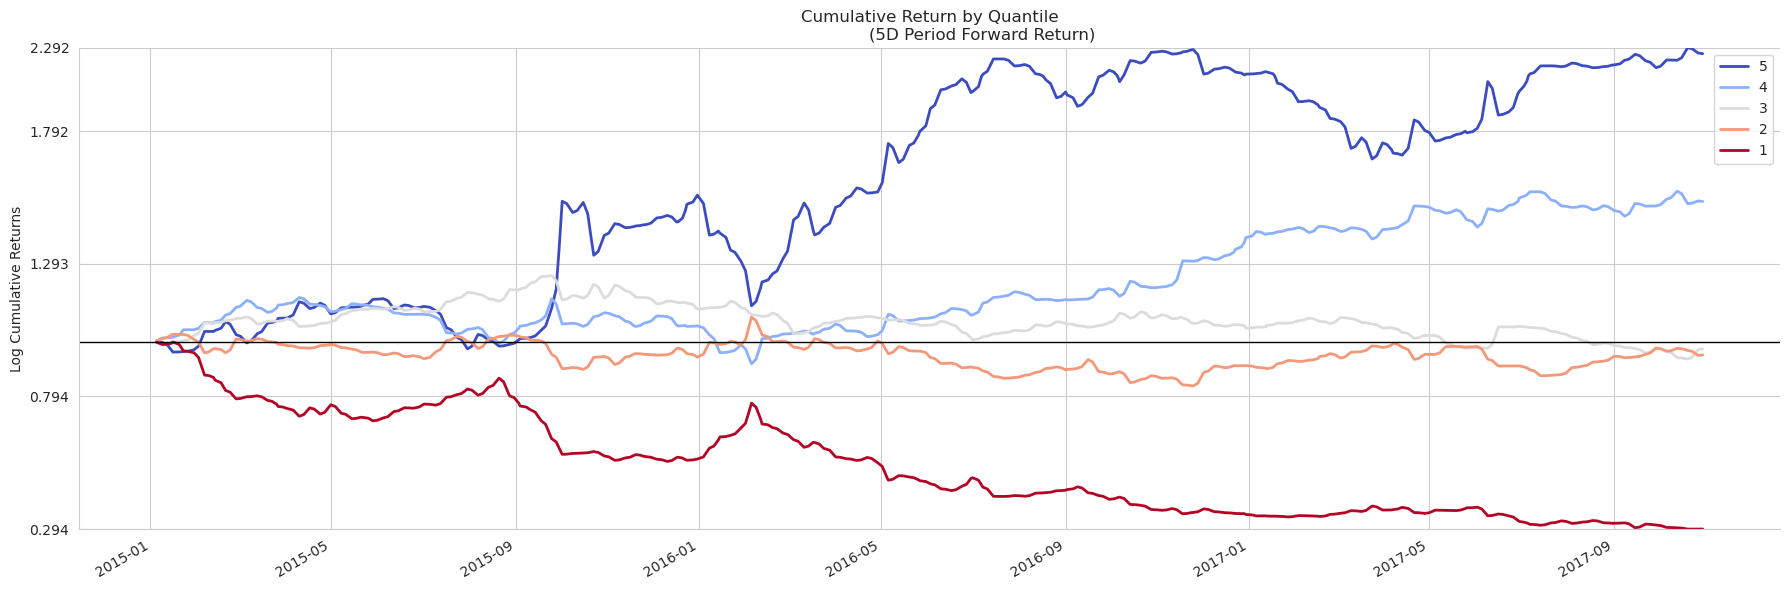

In [27]:
plot_cumulative_returns_by_quantile(mean_return_by_q_daily['5D'], period='5D', freq=None)
plt.tight_layout()
sns.despine();

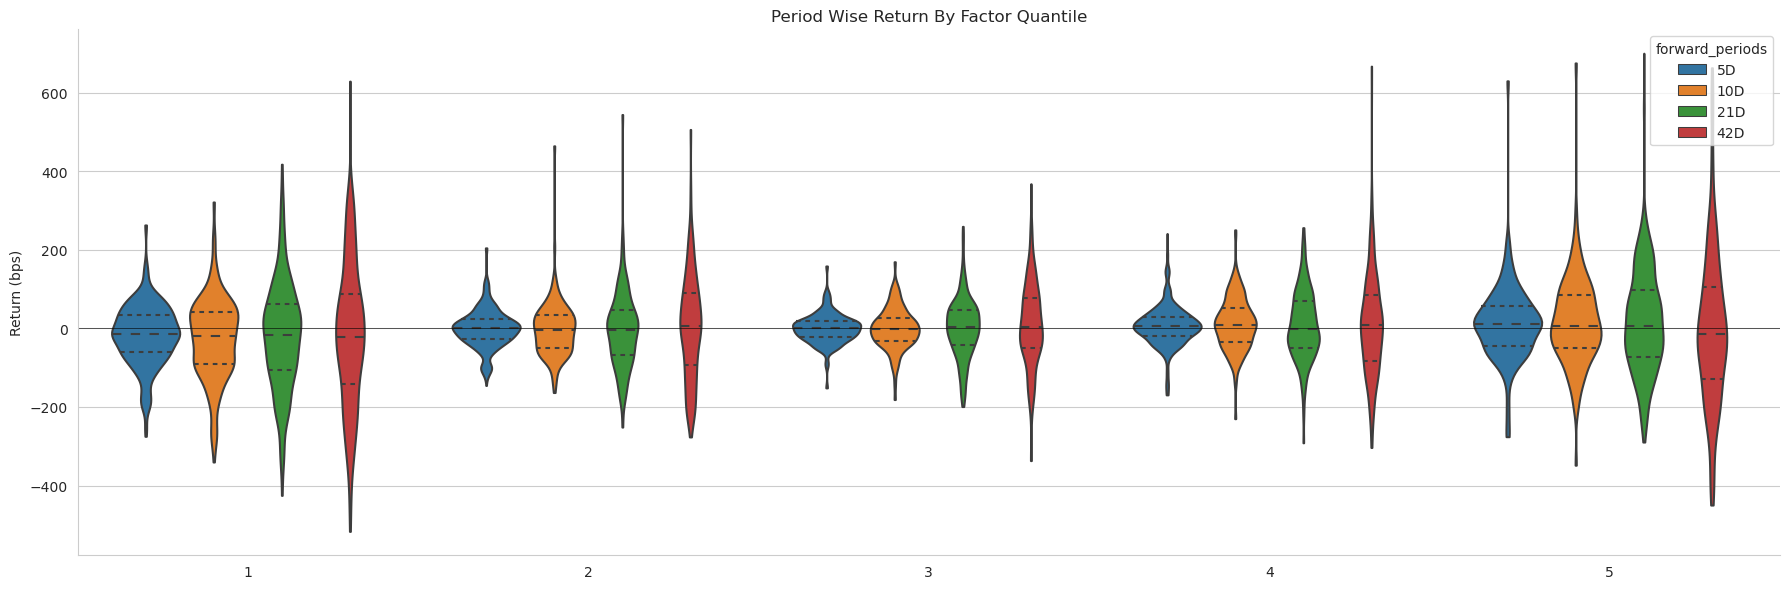

In [28]:
plot_quantile_returns_violin(mean_return_by_q_daily)
plt.tight_layout()
sns.despine();

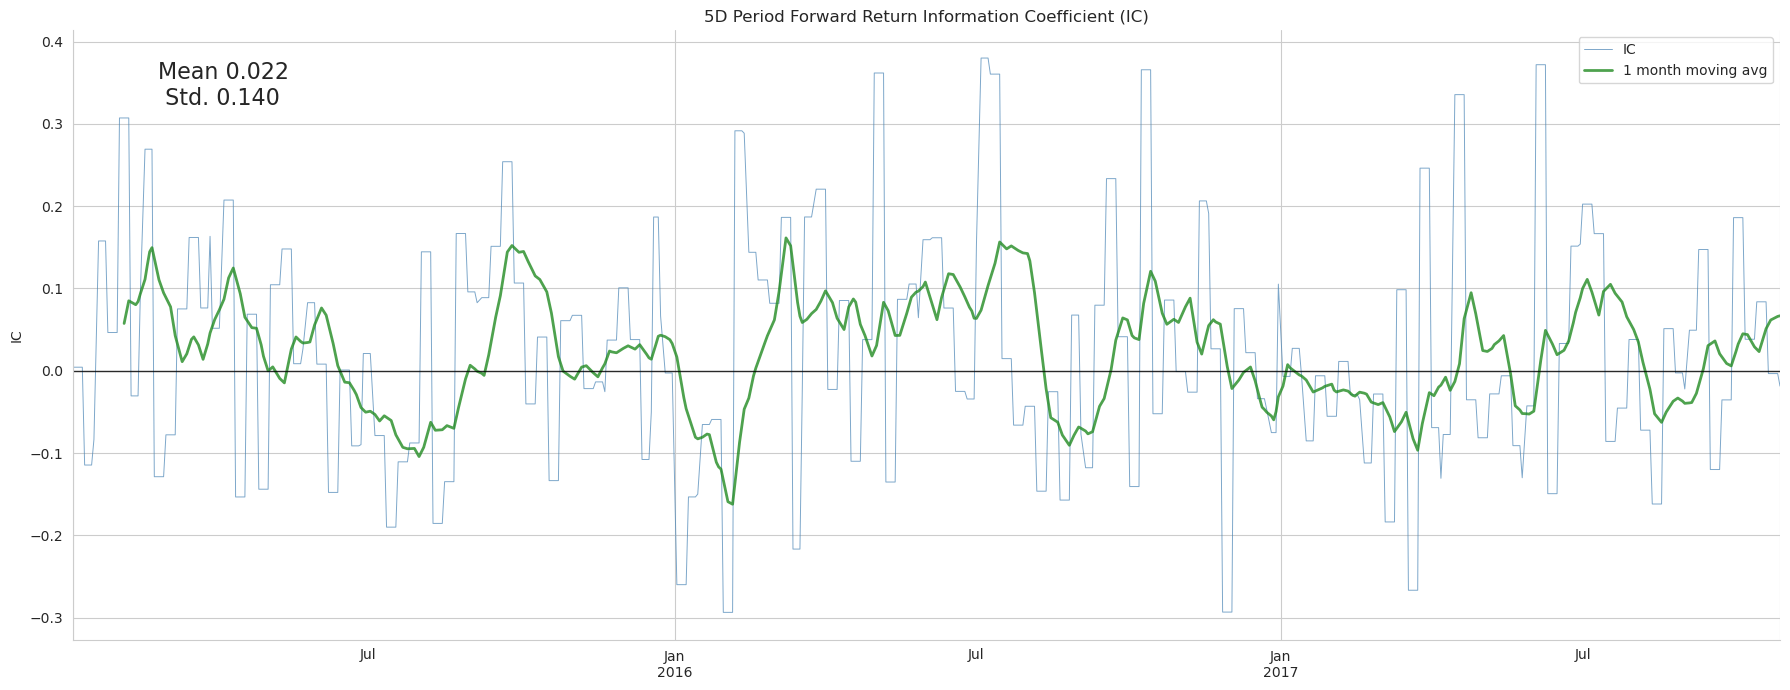

In [29]:
ic = factor_information_coefficient(alphalens_data)
plot_ic_ts(ic[['5D']])
plt.tight_layout()
sns.despine();

In [30]:
ic = factor_information_coefficient(alphalens_data)
ic.info()
ic.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 712 entries, 2015-01-05 00:00:00+00:00 to 2017-10-30 00:00:00+00:00
Freq: C
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5D      712 non-null    float64
 1   10D     712 non-null    float64
 2   21D     712 non-null    float64
 3   42D     712 non-null    float64
dtypes: float64(4)
memory usage: 27.8 KB


,5D,10D,21D,42D
date,,,,
2015-01-05 00:00:00+00:00,0.004366,-0.010634,-0.009467,0.087429
2015-01-06 00:00:00+00:00,0.004366,-0.010634,-0.009467,0.058292
2015-01-07 00:00:00+00:00,0.004366,-0.010634,-0.009467,0.058292
2015-01-08 00:00:00+00:00,0.004366,-0.010634,0.036361,0.058292
2015-01-09 00:00:00+00:00,0.004366,-0.009452,0.036361,0.058292


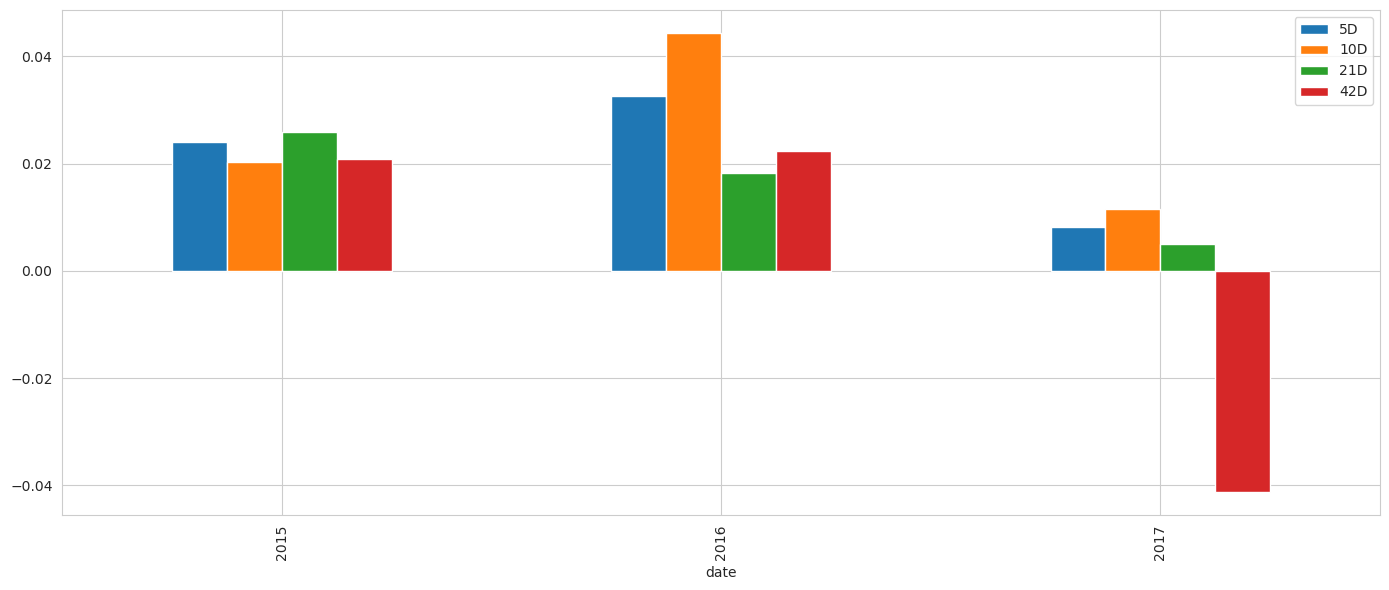

In [21]:
ic = factor_information_coefficient(alphalens_data)
ic_by_year = ic.resample('A').mean()
ic_by_year.index = ic_by_year.index.year
ic_by_year.plot.bar(figsize=(14, 6))
plt.tight_layout();

Turnover Analysis


,5D,10D,21D,42D
Quantile 1 Mean Turnover,0.411,0.590,0.830,0.831
Quantile 2 Mean Turnover,0.645,0.740,0.804,0.812
Quantile 3 Mean Turnover,0.679,0.765,0.808,0.812
Quantile 4 Mean Turnover,0.642,0.741,0.810,0.814
Quantile 5 Mean Turnover,0.394,0.569,0.811,0.819


,5D,10D,21D,42D
Mean Factor Rank Autocorrelation,0.713,0.454,-0.013,-0.017


<Figure size 640x480 with 0 Axes>

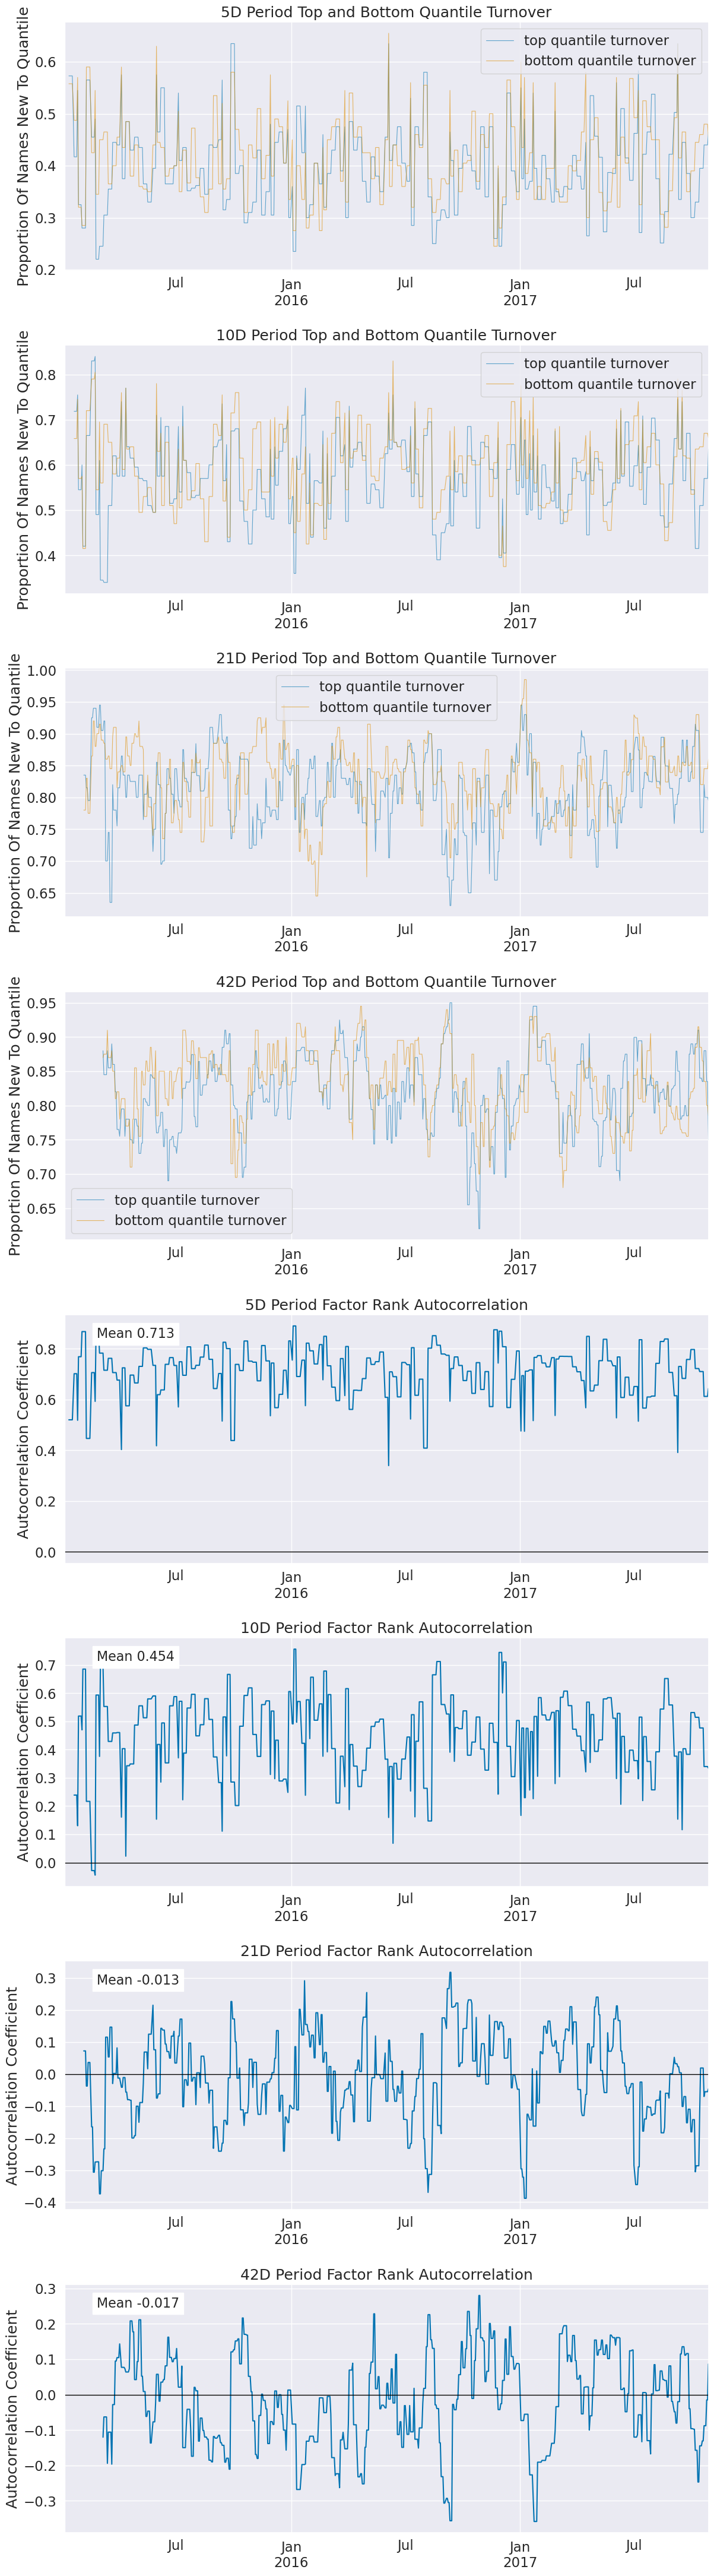

In [22]:
create_turnover_tear_sheet(alphalens_data);